Valence-Bond DMFT solution of the Hubbard model
============================

In this notebook you will reproduce results for the 2D square lattice $t-t'$ Hubbard model using a minimal cluster extension (2-Patch DCA) of DMFT as published in Ref. [Phys. Rev. B **80**, 064501 (2009)](https://arxiv.org/abs/0903.2480)

For further reference see also:

[Europhys. Lett. **85**, 57009 (2009)](https://arxiv.org/abs/0806.4383)

[Phys. Rev. B **82**, 054502 (2010)](https://arxiv.org/abs/1001.5051)

[Phys. Rev. B **82**, 155101 (2010)](https://arxiv.org/abs/1007.2592)

This calculation represents an approach to the normal state of cuprate superconductors. It is based on an effective two-impurity model embedded in a self-consistent bath. The two degrees of freedom of this effective model can be associated to the nodal and antinodal regions of momentum space. It allows to find a metal-insulator transition which is selective in momentum space: At low doping quasiparticles are destroyed in the antinodal region, while they remain protected in the nodal region, leading to the formation of apparent Fermi arcs. 

We are considering the Hubbard Hamiltonian 

$$H = \sum_{{\mathbf k}, \sigma = \uparrow,\downarrow}
{\varepsilon_{\mathbf k}} c^{\dagger}_{\sigma {\mathbf k}} c_{\sigma {\mathbf k}} + U \sum_{i} n_{i\downarrow} n_{i\uparrow}$$

with

$${\varepsilon_{\mathbf k}} = -2t \bigl [\cos(k_{x}) + \cos (k_{y}) \bigr] -4t' \cos(k_{x}) \cos(k_{y})$$.

In the following, we use $U/t=10$ and $t'/t=-0.3$, which are values commonly used for modeling
hole-doped cuprates in a single-band framework. 
All energies (and temperatures) are expressed in units of $D=4t=1$, and
the doping is denoted by $\delta$.

We subdivide the Brillouin Zone into a minimal set of two patches of **equal** area
$P_+$ (even) and $P_-$ (odd).

<img src="imgs/vb-patching.png" width="240" height="180" border="10">

$P_+$ is a central square centered at momentum $(0,0)$ and containing the nodal region;
the complementary region $P_{-}$ extends to the edge of the BZ and contains in particular
the antinodal region and the $(\pi,\pi)$ momentum.



In [1]:
from triqs.gf import *
from triqs.operators import *
from triqs_cthyb import Solver
from h5 import HDFArchive
import triqs.utility.mpi as mpi
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Redirect the output of the C++ solver to the notebook
from triqs.utility.redirect import *
start_redirect()

Starting serial run at: 2023-08-28 17:37:07.323600


<i class="fa fa-gear fa-x" style="color: #186391"></i> Exercise 1
----------

Create a 2-dimensional grid of k-points ($1000 \times 1000$) covering the Brillouin zone,

and build the corresponding grid of kinetic energies (*Hint*: Have a look at numpy's linspace and meshgrid)

Finally, make a contourplot of the dispersion relation. 

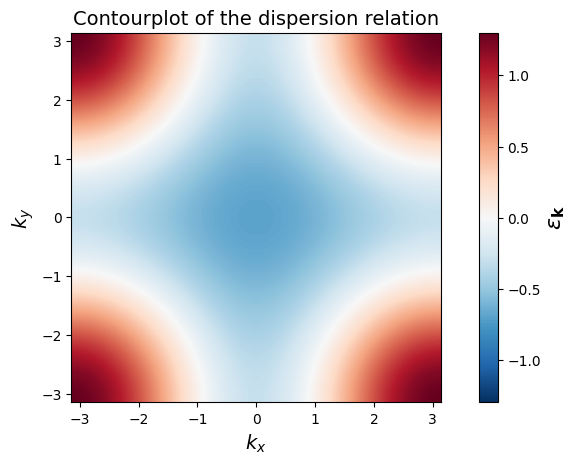

In [2]:
# Parameters
t = 0.25
tp = -0.3*t
U = 10.*t
beta = 200./(4*t)
mu = 0.6155 # Corresponds to a doping of 0.04

# Get the dispersion over the BZ
k_linear = np.linspace(-np.pi, np.pi, 1000, endpoint=False)
kx, ky = np.meshgrid(k_linear, k_linear)
epsk = -2 * t * (np.cos(kx) + np.cos(ky)) - 4 * tp * np.cos(kx) * np.cos(ky)

plt.pcolormesh( k_linear, k_linear, epsk, cmap='RdBu_r', shading='auto', vmin=-1.3, vmax=1.3)
plt.colorbar().set_label(r'$\epsilon_\mathbf{k}$', fontsize=16)
plt.xlabel('$k_x$', fontsize=14)
plt.ylabel('$k_y$', fontsize=14)
plt.axis('scaled')
plt.title("Contourplot of the dispersion relation", fontsize = 14)
plt.show()

<i class="fa fa-gear fa-x" style="color: #186391"></i> Exercise 2
----------

You will now calculate the partial density of states for both the even and odd patch.
For this it is useful to create a normalized histogram for each patch and bin the kinetic energies you
calculated into the corresponding histogram.

Plot the partial density of states for both patches and compare with Fig. 2 of [Phys. Rev. B **80**, 064501 (2009)](https://arxiv.org/abs/0903.2480)

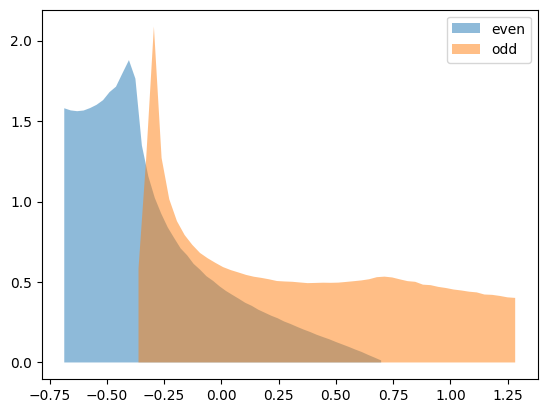

In [3]:
# A mask giving the k points inside the central patch
in_central_patch = (np.abs(kx) < np.pi/np.sqrt(2)) & (np.abs(ky) < np.pi/np.sqrt(2))

# The number of bins for used in the Histogram
n_bins = 50

# Find the partial densities of states associated to the patches
energies, epsilon, rho, delta = {},{}, {}, {}
energies['even'] = np.extract(in_central_patch, epsk)
energies['odd'] = np.extract(np.invert(in_central_patch), epsk)

for patch in ['even','odd']:
    h = np.histogram(energies[patch], bins=n_bins, density=True)
    epsilon[patch] = 0.5 * (h[1][0:-1] + h[1][1:])
    rho[patch] = h[0]
    delta[patch] = h[1][1]-h[1][0]
    plt.fill_between(epsilon[patch], rho[patch], lw=3, label=patch, alpha=0.5)
    
plt.legend()
plt.show()

<i class="fa fa-gear fa-x" style="color: #186391"></i> Exercise 3
----------

Calculate the local Hamiltonian of the two-site impurity

$H_\mathrm{loc} = U ( n_{1,\uparrow} n_{1,\downarrow} + n_{2,\uparrow} n_{2,\downarrow} )$

in the even-odd basis

$c_{\pm,\sigma} = (c_{1,\sigma} \pm c_{2,\sigma})/\sqrt{2}$

Recall that Hamiltonians can be easily build using the creation and annihilation operators `c` and `c_dag=dagger(c)`
of the TRIQS library

In [4]:
# Calculate the creation/annihilation operators in the site basis by means of the even/odd basis
cn, cn_dag, nn = {}, {}, {}
for spin in ['up','down']:
    cn['1-%s'%spin] = (c('even-%s'%spin,0) + c('odd-%s'%spin,0)) / np.sqrt(2)
    cn['2-%s'%spin] = (c('even-%s'%spin,0) - c('odd-%s'%spin,0)) / np.sqrt(2)
    nn['1-%s'%spin] = dagger(cn['1-%s'%spin]) * cn['1-%s'%spin]
    nn['2-%s'%spin] = dagger(cn['2-%s'%spin]) * cn['2-%s'%spin]

# Local Hamiltonian
h_loc = U * (nn['1-up'] * nn['1-down'] + nn['2-up'] * nn['2-down'])

<i class="fa fa-gear fa-x" style="color: #186391"></i> Exercise 4
----------

We do now have all the ingredients to set up the DMFT loop.
According to the DCA Equations we update the Weiss field as

$${\cal G}_0^{-1} = G^{-1} + \Sigma$$

with

$$G_{\pm,\sigma} = \int d\epsilon \, \frac{\rho_{\pm,\sigma}(\epsilon)}{i\omega + \mu - \epsilon - \Sigma_{\pm,\sigma}}$$

Fill the missing self-consistency condition into the empty DMFT Loop below.

In [5]:
# Construct the impurity solver
S = Solver(beta = beta,
           gf_struct = [('even-up',1), ('odd-up',1), ('even-down',1), ('odd-down',1)], n_l = 100)

# The local lattice Green's function
G = S.G0_iw.copy()

# Initial guess
S.Sigma_iw << mu

# DMFT loop
n_loops = 10
for it in range(n_loops):
    
    # DCA self-consistency - get local lattice G
    G.zero()
    for spin in ['up', 'down']:
        for patch in ['even', 'odd']:
            # Hilbert transform
            for i in range(n_bins):
                G['%s-%s'%(patch,spin)] += rho[patch][i] * delta[patch] * \
                    inverse(iOmega_n + mu - epsilon[patch][i] - S.Sigma_iw['%s-%s'%(patch,spin)])

    # DCA self-consistency - find next impurity G0
    for block, g0 in S.G0_iw:
        g0 << inverse(inverse(G[block]) + S.Sigma_iw[block])

    # Run the solver. The results will be in S.G_tau, S.G_iw and S.G_l
    S.solve(h_int = h_loc,                           # Local Hamiltonian
            n_cycles  = 10000,                       # Number of QMC cycles
            length_cycle = 10,                       # Length of one cycle
            n_warmup_cycles = 1000,                  # Warmup cycles
            measure_G_l = True)                      # Measure G_l
    
    if mpi.is_master_node():
        with HDFArchive("results.h5") as A:
            A['G_iw-%i'%it] = S.G_iw
            A['Sigma_iw-%i'%it] = S.Sigma_iw
            A['G0_iw-%i'%it] = S.G0_iw

## Analyzing the precomputed results

Converging the above DMFT for the given parameters is unfortunately a longer calculation on multiple cores.

We have however provided precomputed results achieved with a version of this Notebook that are provided in the
`data/vbdmft` subfolder.

The following cell plots the real and imaginary part of both the odd and even Green's function.
One can clearly observe how the odd Green's function becomes insulating as one approaches the half-filled case, while the even Green's function remains metallic. The pseudogap physics can thus be captured qualitatively already with this rather rough DCA patching scheme.

This plots below can be directly compared with Fig. 25 of Phys. Rev. B **80**, 064501 (2009).

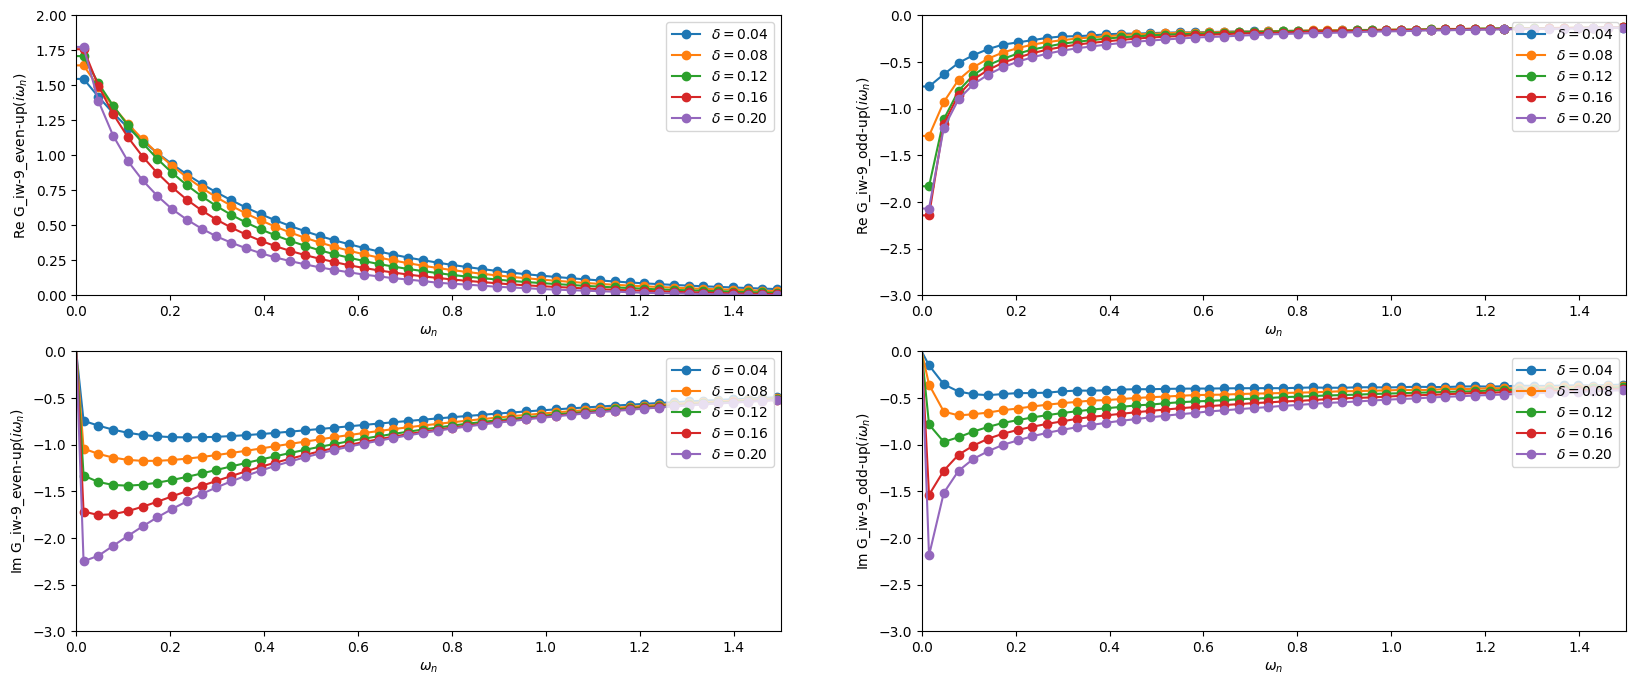

In [6]:
from triqs.plot.mpl_interface import *

plt.figure(figsize=(20,8))

plt.subplot(2,2,1)
for doping in ["0.04","0.08","0.12","0.16","0.20"]:
    with HDFArchive("data/vbdmft/doping_%s.h5"%doping,'r') as A:
        i = 9
        oplot(A['G_iw-%i'%i]['even-up'].real, '-o', label="$\delta = %s$"%doping)
plt.xlim(0,1.5)
plt.ylim(0,2)

plt.subplot(2,2,2)
for doping in ["0.04","0.08","0.12","0.16","0.20"]:
    with HDFArchive("data/vbdmft/doping_%s.h5"%doping,'r') as A:
        i = 9
        oplot(A['G_iw-%i'%i]['odd-up'].real, '-o', label="$\delta = %s$"%doping)
plt.xlim(0,1.5)
plt.ylim(-3,0)

plt.subplot(2,2,3)
for doping in ["0.04","0.08","0.12","0.16","0.20"]:
    with HDFArchive("data/vbdmft/doping_%s.h5"%doping,'r') as A:
        i = 9
        oplot(A['G_iw-%i'%i]['even-up'].imag, '-o', label="$\delta = %s$"%doping)
plt.xlim(0,1.5)
plt.ylim(-3,0)

plt.subplot(2,2,4)
for doping in ["0.04","0.08","0.12","0.16","0.20"]:
    with HDFArchive("data/vbdmft/doping_%s.h5"%doping,'r') as A:
        i = 9
        oplot(A['G_iw-%i'%i]['odd-up'].imag, '-o', label="$\delta = %s$"%doping)
plt.xlim(0,1.5)
plt.ylim(-3,0)

plt.show()